# Analyze A/B Test Results 

This project will assure you have mastered the subjects covered in the statistics lessons. We have organized the current notebook into the following sections: 

- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Conclusion](#conclusion)

Specific programming tasks are marked with a **ToDo** tag. 

<a id='intro'></a>
## Introduction

A/B tests are very commonly performed by data analysts and data scientists. For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should:
- Implement the new webpage, 
- Keep the old webpage, or 
- Perhaps run the experiment longer to make their decision.

<a id='probability'></a>
## Part I - Probability

To get started, let's import our libraries.

In [206]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

### ToDo 1.1

**a.** Read in the dataset from the `ab_data.csv` file and take a look at the top few rows here:

In [207]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


**b.** Use the cell below to find the number of rows in the dataset.

In [208]:
df.shape

(294478, 5)

**c.** The number of unique users in the dataset.

In [209]:
df['user_id'].nunique()

290584

**d.** The proportion of users converted.

In [210]:
df.converted.mean()

0.11965919355605512

**e.** The number of times when the "group" is `treatment` but "landing_page" is not a `new_page`.

In [211]:
mismatch1 = df.query('group == "treatment" and landing_page != "new_page"').count()
mismatch2 = df.query('group == "control" and landing_page != "old_page"').count()
mismatch1 + mismatch2

user_id         3893
timestamp       3893
group           3893
landing_page    3893
converted       3893
dtype: int64

**f.** Do any of the rows have missing values?

In [212]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


### ToDo 1.2  
**a.** Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [213]:
# Remove the inaccurate rows, and store the result in a new dataframe df2
df.drop(df.query('group == "treatment" and landing_page != "new_page"').index, inplace=True)
df.drop(df.query('group == "control" and landing_page != "old_page"').index, inplace=True)

In [214]:
# Double Check all of the incorrect rows were removed from df2 - 
# Output of the statement below should be 0
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290585 entries, 0 to 294477
Data columns (total 5 columns):
user_id         290585 non-null int64
timestamp       290585 non-null object
group           290585 non-null object
landing_page    290585 non-null object
converted       290585 non-null int64
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


In [215]:
# Save to new csv
df2 = df.to_csv('ab_edited.csv',index= False)
# Read the new csv
df2 = pd.read_csv('ab_edited.csv')
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [216]:
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

## ToDo 1.3  
Use **df2** and the cells below to answer questions for **Quiz 3** in the classroom.

**a.** How many unique **user_id**s are in **df2**?

In [217]:
df2['user_id'].nunique()

290584

**b.** There is one **user_id** repeated in **df2**.  What is it?

In [218]:
df2['user_id'].duplicated().any().sum()

1

**c.** Display the rows for the duplicate **user_id**? 

In [219]:
# Display the duplicated values
df2[df2.duplicated(['user_id'], keep=False)]

,user_id,timestamp,group,landing_page,converted
1876,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2862,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


**d.** Remove **one** of the rows with a duplicate **user_id**, from the **df2** dataframe.

In [220]:
# Keep the first value
df2 = df2[~df2.user_id.duplicated(keep='first')]
# Check again if the row with a duplicate user_id is deleted or not
df2.shape

(290584, 5)

### ToDo 1.4  
Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

**a.** What is the probability of an individual converting regardless of the page they receive?<br><br>

In [221]:
df['converted'].mean()

0.11959667567149027

**b.** Given that an individual was in the `control` group, what is the probability they converted?

In [222]:
df2_control = df2.query('group == "control"')
df2_control.converted.mean()

0.1203863045004612

**c.** Given that an individual was in the `treatment` group, what is the probability they converted?

In [223]:
df2_treatment = df2.query('group == "treatment"')
df2_treatment.converted.mean()

0.11880806551510564

In [224]:
# Calculate the actual difference (obs_diff) between the conversion rates for the two groups.
obs_diff = df2_treatment.converted.mean() - df2_control.converted.mean()
obs_diff

-0.0015782389853555567

**d.** What is the probability that an individual received the new page?

In [225]:
len(df2_treatment.index)/len(df2.index)

0.5000619442226688

**e.** Consider your results from parts (a) through (d) above, and explain below whether the new `treatment` group users lead to more conversions.


>**Answer: Although the control group leads in conversion rate** where the control(the old page) does better with (0.120386) while the new page with (0.118807), by a small margin that is 0.00158. This might make us think that the treatment group does not lead to more conversions than the control group, hence ignoring the small margin outlined.

<a id='ab_test'></a>
## Part II - A/B Test

Since a timestamp is associated with each event, you could run a hypothesis test continuously as long as you observe the events. 

### ToDo 2.1
For now, consider you need to make the decision just based on all the data provided.  

>**Answer:** 
Hypothesis

 > * H<sub>0</sub>:  P<sub>old</sub> >= P<sub>new</sub> 
 > * H<sub>0</sub>:  P<sub>old</sub> < P<sub>new</sub>

>Noting from conversion rate the old page is better than the new page by a small margin, unless with the subsequent continous tests the P<sub>new</sub> gets better than the P<sub>old</sub> which will give us the a null hypothesis. If the Pnew is better than the old then then this is the alternative hypothesis.

### ToDo 2.2 - Null Hypothesis $H_0$ Testing
In this section, you will: 

- Simulate (bootstrap) sample data set for both groups, and compute the  "converted" probability $p$ for those samples. 


- Use a sample size for each group equal to the ones in the `df2` data.


- Compute the difference in the "converted" probability for the two samples above. 


- Perform the sampling distribution for the "difference in the converted probability" between the two simulated-samples over 10,000 iterations; and calculate an estimate. 


In [226]:
converted_mean = df['converted'].mean()
converted_mean

0.11959667567149027

**a.** What is the **conversion rate** for $p_{new}$ under the null hypothesis? 

In [227]:
p_new  = df2.converted.mean()
p_new

0.11959708724499628

**b.** What is the **conversion rate** for $p_{old}$ under the null hypothesis? 

In [228]:
p_old = df2.converted.mean()
p_old

0.11959708724499628

**c.** What is $n_{new}$, the number of individuals in the treatment group? <br><br>

In [229]:
n_new = len(df2.query("group == 'treatment'"))
n_new

145310

**d.** What is $n_{old}$, the number of individuals in the control group?

In [230]:
n_old = len(df2.query("group == 'control'"))
n_old

145274

**e. Simulate Sample for the `treatment` Group**<br> 
Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null hypothesis.  <br><br>


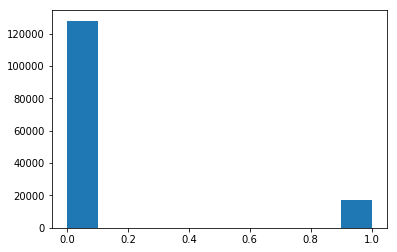

In [231]:
# Simulate a Sample for the treatment Group
new_page_converted = np.random.choice([1, 0], size=len(df2_treatment.index), p=[df2.converted.mean(), (1-(df2.converted.mean()))])
plt.hist(new_page_converted);

**f. Simulate Sample for the `control` Group** <br>
Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null hypothesis. <br> Store these $n_{old}$ 1's and 0's in the `old_page_converted` numpy array.

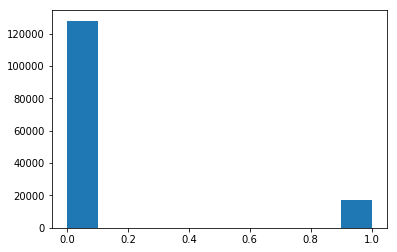

In [232]:
# Simulate a Sample for the control Group
old_page_converted = np.random.choice([1, 0], size=len(df2_control.index), p=[df2.converted.mean(), (1-(df2.converted.mean()))])
plt.hist(old_page_converted);

**g.** Find the difference in the "converted" probability $(p{'}_{new}$ - $p{'}_{old})$ for your simulated samples from the parts (e) and (f) above. 

In [233]:
#the new page has new_page_converted and old_page_converted have different sizes, we cannot directly compute p_diff
new_page_converted.mean() - old_page_converted.mean()

0.0010166252471781462


**h. Sampling distribution** <br>
Re-create `new_page_converted` and `old_page_converted` and find the $(p{'}_{new}$ - $p{'}_{old})$ value 10,000 times using the same simulation process you used in parts (a) through (g) above. 

<br>
Store all  $(p{'}_{new}$ - $p{'}_{old})$  values in a NumPy array called `p_diffs`.

In [234]:
# Sampling distribution
p_diffs = []
new_page_converted = np.random.binomial(n_new, df2.converted.mean(),  10000)/n_new

old_page_converted = np.random.binomial(n_old, df2.converted.mean(),  10000)/n_old

diffs = new_page_converted - old_page_converted
p_diffs.append(diffs)

**i. Histogram**<br> 
Plot a histogram of the **p_diffs**.  Does this plot look like what you expected? <br> 

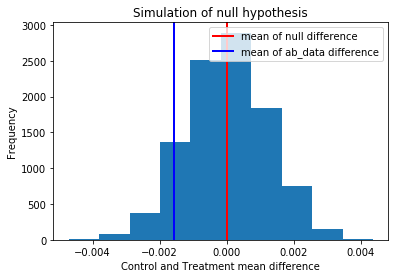

In [235]:
plt.title('Simulation of null hypothesis')
plt.xlabel('Control and Treatment mean difference')
plt.ylabel('Frequency');
low = obs_diff

high = (np.array(p_diffs).mean())
plt.axvline(x=high, color='r', linewidth=2, label='mean of null difference')
plt.axvline(x=low, color='b', linewidth=2, label='mean of ab_data difference')
plt.legend()
plt.hist(p_diffs);

**j.** What proportion of the **p_diffs** are greater than the actual difference observed in the `df2` data?

In [236]:
obs_diff = df2_treatment.converted.mean() - df2_control.converted.mean()
(p_diffs > obs_diff).mean()

0.90990000000000004

**k.** Please explain in words what you have just computed in part **j** above.  
 - What is this value called in scientific studies?  
 - What does this value signify in terms of whether or not there is a difference between the new and old pages?

>**Answer:** 
* We are computing p-values here.
* The proportion of the p_diffs that are greater than the actual difference observed in ab_data.csv is called the **p-value**
* A p-value is the probability of observing your statistic if the null hypothesis is true.
* The null hypothesis was that the difference in means would be equal or less than 0, and the alternative was the difference would be greater than 0



**l. Using Built-in Methods for Hypothesis Testing**<br>

Fill in the statements below to calculate the:
- `convert_old`: number of conversions with the old_page
- `convert_new`: number of conversions with the new_page
- `n_old`: number of individuals who were shown the old_page
- `n_new`: number of individuals who were shown the new_page


In [237]:
import statsmodels.api as sm

# number of conversions with the old_page
convert_old = len(df2_control[df2_control['converted'] == 1])

# number of conversions with the new_page
convert_new = len(df2_treatment[df2_treatment['converted'] == 1])

# number of individuals who were shown the old_page
n_old = len(df2_control.index)

# number of individuals who received new_page
n_new = len(df2_treatment.index)

**m.** Now use `sm.stats.proportions_ztest()` to compute your test statistic and p-value.  [Here]
#### About the two-sample z-test 
Another way for comparing the mean of two independent and normal distribution is a **two-sample z-test**. You can perform the Z-test to calculate the Z_score, as shown in the equation below:

$$
Z_{score} = \frac{ (p{'}_{new}-p{'}_{old}) - (p_{new}  -  p_{old})}{ \sqrt{ \frac{\sigma^{2}_{new} }{n_{new}} + \frac{\sigma^{2}_{old} }{n_{old}}  } }
$$

where,
- $p{'}$ is the "converted" success rate in the sample
- $p_{new}$ and $p_{old}$ are the "converted" success rate for the two groups in the population. 
- $\sigma_{new}$ and $\sigma_{new}$ are the standard deviation for the two groups in the population. 
- $n_{new}$ and $n_{old}$ represent the size of the two groups or samples (it's same in our case)


In [238]:
import statsmodels.api as sm
# ToDo: Complete the sm.stats.proportions_ztest() method arguments
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
print(z_score, p_value)

1.31092419842 0.905058312759


**n.** What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?<br>

>**Answer:** The new page's convertion rate is 1.23 which is less than the standard z-score against the standard z-score of range(-1.96 or 1.96), we therefore cannot reject the null hypothesis that the difference between the twi conversion rates is no different from zero.<br>
Then p-value is  0.886. The alternative hypothesis was that the old page converted more than or equal to the new page. 

<a id='regression'></a>
### Part III - A regression approach

### ToDo 3.1 
In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

**a.** Since each row in the `df2` data is either a conversion or no conversion, what type of regression should you be performing in this case?

>**Answer: Logistic regression** 

**b.** The goal is to use **statsmodels** library to fit the regression model you specified in part **a.** above to see if there is a significant difference in conversion based on the page-type a customer receives. However, you first need to create the following two columns in the `df2` dataframe:
 1. `intercept` - It should be `1` in the entire column. 
 2. `ab_page` - It's a dummy variable column, having a value `1` when an individual receives the **treatment**, otherwise `0`.  

In [239]:
df2['intercept'] = 1
df2[['new_page', 'old_page']] = pd.get_dummies(df2['landing_page'])
df2[['control', 'ab_page']] = pd.get_dummies(df2['group'])
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,new_page,old_page,control,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,1,0


**c.** Use **statsmodels** to instantiate your regression model on the two columns you created in part (b). above, then fit the model to predict whether or not an individual converts. 


In [240]:
import statsmodels.api as sm
ab_page_index = df2[df2['group']=='treatment'].index
df2.loc[ab_page_index, "ab_page"] = 1
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,new_page,old_page,control,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,1,0


In [241]:
logit_m = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])

**d.** Provide the summary of your model below, and use it as necessary to answer the following questions.

In [242]:
results=logit_m.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-10-03 15:41 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

**e.** What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br>


>**Answer:** 
Our hypothesis here is:
* H<sub>0</sub>:P<sub>new</sub>  - P<sub>old</sub>  =  0
* H<sub>1</sub>: P<sub>new</sub> - P<sub>old</sub>  !=  0
* The p-value calculated here is 0.190. This is because the Logit Regression is based on a two-tailed test as compared with the previous hypothesis we cannot reject our null hypothesis.

**f.** Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

>**Answer:** 
* The convert rate may be related to some features of users like nationality, age, gender or specific cultural behavior.
* Adding additional information about users could reveal hidden value of the new version of the page for specific group of the users.
* The disadvantages to adding additional terms into the regression model is that even with additional factors we can never account for all influencing factors or accomodate them. Plus, small pilots and pivots sometimes work better in practice than long-drawn research without execution.

**g. Adding countries**<br> 
Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. <br>
 Provide the statistical output as well as a written response to answer this question.

In [243]:
# Read the countries.csv
df_countries = pd.read_csv('./countries.csv')
df_new = df_countries.set_index('user_id').join(df2.set_index('user_id'
), how='inner')

In [244]:
#Check unique countries
df_new['country'].unique()

array(['UK', 'US', 'CA'], dtype=object)

In [245]:
df_new[['CA', 'UK', 'US']] = pd.get_dummies(df_new['country'])
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,new_page,old_page,control,ab_page,CA,UK,US
user_id,,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,0,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,0,1,0,1,0


In [246]:
df_new = df_new.drop(['CA'], axis=1)

# check result
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,new_page,old_page,control,ab_page,UK,US
user_id,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,1,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,0,1,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,1,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,0,1,1,0


In [247]:

# logistic regression for the intersection above using Logit
model = sm.Logit(df_new['converted'], df_new[['intercept','new_page','UK','US']])
result = model.fit()
result.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-10-03 15:41 AIC:              212781.1253
No. Observations:   290584           BIC:              212823.4439
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290580           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0300    0.0266  -76.2488  0.0000  -2.0822  -1.9778
new_page      -0.0149    0.0114   -1.3069  0.1912  -0.0374   0.0075
UK             0.0506    0.0284    1.7835  0.0745  -0.0050   0.1063
US             0.0408    0.0269    1.5161  0.1295  -0.0119   0.0934
==================================================================

"""

#### Results:
* For each new page decrease, conversion will happen by 1.5%.
* For each UK increase, conversion will happen by 5%.
* For each US increase, conversion will happen by 4.9%.


**h**. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion. Create the necessary additional columns, and fit the new model.

In [248]:
#Fit your model, and summarize the results
# logit_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'CA', 'UK']])
# results = logit_mod.fit()
# #summary2() is an alternative of summary()
# results.summary2()

df_new['UK_new'] = df_new['new_page']* df_new['UK']
df_new['US_new'] = df_new['new_page']* df_new['US']

# check result
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,new_page,old_page,control,ab_page,UK,US,UK_new,US_new
user_id,,,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,1,0,1,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1,0,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,0,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,1,0,1,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,0,1,1,0,1,0


In [249]:
# logistic regression for the intersection above using Logit
model = sm.Logit(df_new['converted'], df_new[['intercept','new_page','UK_new','US_new','UK','US']])
result = model.fit()
result.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-10-03 15:41 AIC:              212782.6602
No. Observations:   290584           BIC:              212846.1381
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0040    0.0364  -55.0077  0.0000  -2.0754  -1.9326
new_page      -0.0674    0.0520   -1.2967  0.1947  -0.1694   0.0345
UK_new         0.0783    0.0568    1.3783  0.1681  -0.0330   0.1896
US_new         0.0469    0.0538    0.8718  0.3833  -0.0585   0.1523
UK             0.0118    0.0398    0.2957  0.7674  -0.0663   0.0899
US             0.0175    0.0377    0.4652  0.6418  -0.0563   0.0914
==================================================================

"""

#### Results
* As shown on the model above, we can see the coefficient of intersected (UK_new and US_new) values are different from new page coefficient. Based on that:
* For each new page decrease, the conversion will happen by 6.7%.
* Conversion for UK_new users will happen by 7.8% more than US_new users.
* Conversion for US_new users will happen by 4.6% more than UK_new users.
* Conversion for UK users will happen by 1.18% more than US users.
* Conversion for US users will happen by 1.75% more than UK users.

**Other tests of Logistic Regression we will peform Recall Score, Precision Score and Accuracy Score to see if we can take landing page and country to predict conversion rate.**

In [250]:
# Reference: Logistic Regression Lesson.
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split
np.random.seed(42)

In [251]:
# define x, y variables
x = df_new[['new_page','UK_new','US_new','UK','US']]
y = df_new['converted']

# create test and train data set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

In [252]:
# Recall, Accuracy and Precision scores
print(precision_score(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(recall_score(y_test,y_pred))

0.0
0.879157561471
0.0


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Result:
* actual no conversion predicts user converts . (actual:- predicted:+)
* Since our accuracy is near to be 1, thats a sign of correctly converted cases, among predicted and test data.
* Recall and Precision equal to 0, that means we are only converted users are counted.
* 0 predicted no conversion did not convert. (actual:- predicted:-)

<a id='conclusion'></a>
### Conclusion
In the end of this analysis the conclusion is that the null hypothesis is not rejected since the margin of the converted users from old to new page in both control and experiment group is small. <br><br>
This is supported by the tests performed in null-hypothesis test, z-tests and further using built in tools to test this. We later add countries to check whether they cause an effect to the conversion rate.

### References

* Udacity Nanodegree resources. <br>
* https://www.statology.org/z-test-python/
* https://towardsdatascience.com/simple-and-multiple-linear-regression-in-python-c928425168f9
* A/B Testing Real-life Example: A Step by Step Walkthrough https://www.youtube.com/watch?v=VuKIN9S8Ivs
* summary() to summary2() https://www.statsmodels.org/stable/generated/statsmodels.discrete.discrete_model.LogitResults.summary2.html?highlight=summary2#statsmodels.discrete.discrete_model.LogitResults.summary2

In [253]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0